In [2]:

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

import sina.datastores.sql as sina_sql
import sina.utils
from sina.datastore import create_datastore
from sina.visualization import Visualizer

from trata import sampler as sm, composite_samples as cs, adaptive_sampler as ad
from ibis import mcmc as mc, plots

# %matplotlib notebook
  
# use this instead of %matplotlib notebook if using vscode, unless you install the matplotlib extension
%matplotlib widget   

Uncertainty Estimation via MCMC
===============================
In our bouncing ball example, we want to estimate the distribution of how many times the ball bounces off the ground until rest given a starting position, velocity, and gravity. 

An MCMC algorithm allows to simulate a probability distribution by constructing a Markov chain with the desired distribution as its stationary distribution. The MCMC algorithm iteratively updates the Markov chain based on the transition probability from one state to another state. Eventually, the chain attains the state of equilibrium when the joint probability distribution for the current state approaches the stationary distribution. The parameters that lead to the stationary distribution are considered as the model parameters learnt for the particular training image. 

Each state of a Markov chain is obtained by sampling a probability distribution. Among various sampling techniques, Metropolis algorithm and Gibbs sampler are two most well-known ones. See the appendix at the bottom for details. 


## Sampling for Uncertainty Quantification

The Gaussian process model requires specification of two kinds of inputs:

1. $x$ = $(x_1,x_2,...,x_p)$ denotes inputs that are under the control of (or are observable by) the experimenter in both the field experiments and the simulator runs. In our bouncing ball example, there are $p=3$ inputs of this type:
    - $x_1=R=1$, the radius of the ball
    - $x_2=D=1$, the density of the ball
    - $x_3=C=0.1$, the coefficient of drag
    
<br>

2. $\theta$ = $(\theta_1,\theta_2,...,\theta_q)$ denotes inputs to the simulator that are needed to estimate using the experimental data. These $\theta$ could correspond to real physical quantities or could be parameters of the simulator code. In our bouncing ball example, there are $q=3$ inputs of this type: 
    - $\theta_1=P=[0,100]$, the initial position of ball
    - $\theta_2=V=[-10,10]$, the initial velocity of the ball
    - $\theta_3=G=[1,10]$, the force of gravity acting on the ball


$\theta$ parameters of the bouncing ball model need to be appropriately sampled in order to build an accurate surrogate that honors the ground truth.

### Generate Data
To get startes we need to generate data by launching our bouncing ball studies by running the command:

`maestro run ball_bounce_suite.yaml --pgen pgen.py`


In [3]:
# Initialization

database = 'output.sqlite'
target_type = "csv_rec"
datastore = create_datastore(database)
recs = datastore.records
vis = Visualizer(datastore)
print("Sina is ready!")


Sina is ready!


In [4]:

groups = set(x["group_id"]["value"] for x in recs.get_data(["group_id"]).values())

print("So far we've run {} experiment groups each with 10 studies.".format(len(groups)))
print("We queried our database and found the following groups: {}".format(groups))


So far we've run 4 experiment groups each with 10 studies.
We queried our database and found the following groups: {'fc8557', 'f5be0b', '9bb55f', 'c6abce'}


Now that we've generated data, we need to load the inputs and output into our Markov chain Monte Carlo. 
Note that for each study in a group, gravity and initial position remain constant. It is the initial velocity of the ball that is changing between each study. 

### Trata

Trata allows a user to create samples using various Bayesian sampling methods. Using Sina, we can easily access our "observed" input data and sample those values using the `DefaultValueSampler`. Had we not been able to, we could have sampled from the parameter ranges outlined above using various sampling methods provided by Trata.

In [5]:
from random import randrange
import statistics as sts
from sklearn.gaussian_process import GaussianProcessRegressor


N = 10*len(groups)/2 # the number of samples should not exceed 10*groups
gravity, x_pos, y_pos, z_pos, x_vel, y_vel, z_vel, bounces = [], [], [], [], [], [], [], []


# instantiating the MCMC object

vanilla_exp = mc.DefaultMCMC()


# accessing and sampling the data for our surrogate model

for group in groups:
    id_pool = list(recs.find_with_data(group_id=group))
    for rec_id in id_pool:
        rec = recs.get(rec_id)

        # data
        data = rec.data_values
        g = data["gravity"]
        gravity.append(g)
        x = data["x_pos_initial"]
        x_pos.append(x)
        y = data["y_pos_initial"]
        y_pos.append(y)
        z = data["z_pos_initial"]
        z_pos.append(z)
        vx = data["x_vel_initial"]
        x_vel.append(vx)
        vy = data["y_vel_initial"]
        y_vel.append(vy)
        vz = data["z_vel_initial"]
        z_vel.append(vz)
        b = data["num_bounces"]
        bounces.append(b)

        
        # setting sample variables

        samples = cs.Samples()
        samples.set_continuous_variable('gravity', 1, g, 10)
        samples.set_continuous_variable('x_pos_initial', 0, x, 100)
        samples.set_continuous_variable('y_pos_initial', 0, y, 100)
        samples.set_continuous_variable('z_pos_initial', 0, z, 100)
        samples.set_continuous_variable('x_vel_initial', -10, vx, 10)
        samples.set_continuous_variable('y_vel_initial', -10, vy, 10)
        samples.set_continuous_variable('z_vel_initial', -10, vz, 10)
        samples.set_continuous_variable('num_bounces', 0, b, 20)


        # generating samples

        samples.generate_samples(['gravity', 'x_pos_initial', 'y_pos_initial','z_pos_initial',
                'x_vel_initial','y_vel_initial','z_vel_initial', 'num_bounces'], sm.DefaultValueSampler(), num_points = N)

        points = samples.get_points(['gravity', 'x_pos_initial', 'y_pos_initial','z_pos_initial',
                'x_vel_initial','y_vel_initial','z_vel_initial'])  


        # the number of observed bounces will serve as our target training data while the target testing data will be randomly generated

        train_num_bounces = samples.get_points(['num_bounces'])
        test_num_bounces = randrange(20)


        # we have opted to use a Guassian Process Regressor as our surrogate model for this problem

        surrogate_model = GaussianProcessRegressor()
        surrogate_model.fit(points, train_num_bounces)  # fitting the model using our parameter samples and the number of bounces


        # adding the output training data and model to our MCMC

        vanilla_exp.add_output('output', 'num_bounces', surrogate_model, test_num_bounces, sts.stdev(bounces) if len(bounces)>1 else 0, 
                ['gravity', 'x_pos_initial', 'y_pos_initial','z_pos_initial','x_vel_initial','y_vel_initial','z_vel_initial'])
        

In [6]:
# calculating sigmas for each input

sig_g = sts.stdev(gravity)
sig_x = sts.stdev(x_pos)
sig_y = sts.stdev(y_pos)
sig_z = sts.stdev(z_pos)
sig_vx = sts.stdev(x_vel)
sig_vy = sts.stdev(y_vel)
sig_vz = sts.stdev(z_vel)
sig_b = sts.stdev(bounces)


# adding the input data to our MCMC

vanilla_exp.add_input('gravity', 1, 10, sig_g)
vanilla_exp.add_input('x_pos_initial', 0, 100, sig_x)
vanilla_exp.add_input('y_pos_initial', 0, 100, sig_y)
vanilla_exp.add_input('z_pos_initial', 0, 100, sig_z)
vanilla_exp.add_input('x_vel_initial', -10, 10, sig_vx)
vanilla_exp.add_input('y_vel_initial', -10, 10, sig_vy)
vanilla_exp.add_input('z_vel_initial', -10, 10, sig_vz)


# running MCMC chain 

vanilla_exp.run_chain(total=10000, burn=10000, every=2, n_chains=16, prior_only=True)
print(vanilla_exp.diagnostics_string())

prior_chains = vanilla_exp.get_chains(flattened=True)
prior_points = np.stack(prior_chains.values()).T

Burning
Burning
Burning
Burning
Burning
Burning
Burning
Burning
Burning

BurningBurning
Burning
Burning
Burning
Burning
Burning
Sampling Start
Sampling StartSampling Start

Sampling Start
Sampling Start
Sampling Start
Sampling Start
Sampling Start
Sampling Start
Sampling Start
Sampling Start
Sampling Start
Sampling Start
Sampling Start
Sampling Start
Sampling: 10%
Sampling: 10%Sampling: 10%

Sampling: 10%
Sampling: 10%
Sampling: 10%Sampling: 10%

Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling Start
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 10%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 30%
Sampling: 30%
Sampling: 30%
Sampling: 30%
Sampling: 30%
Sampling: 30%
Sampling: 30%Sampling: 30%

Sampling: 30%
Sampling: 30%
Sampling: 20%Sampling: 30%

Sampling: 30%Sampling: 30%

Sa

/g/g20/eljurf1/weave_demos/ball_bounce/ball_bounce_demo_venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3473: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


### Trace and autocorrelation plots for each input parameter

In [9]:
def auto_trace(params):
    for param in params:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
        vanilla_exp.trace_plot(param, ax=axes[0])
        vanilla_exp.autocorr_plot(param, ax=axes[1])
        axes[0].title.set_text("{} trace plot".format(param))
        axes[0].set(xlabel="iteration", ylabel="{} value".format(param))
        axes[1].title.set_text("{} autocorrelation plot".format(param))
        axes[1].set(xlabel="lag", ylabel="ACF")
        fig.tight_layout()
        plt.show()

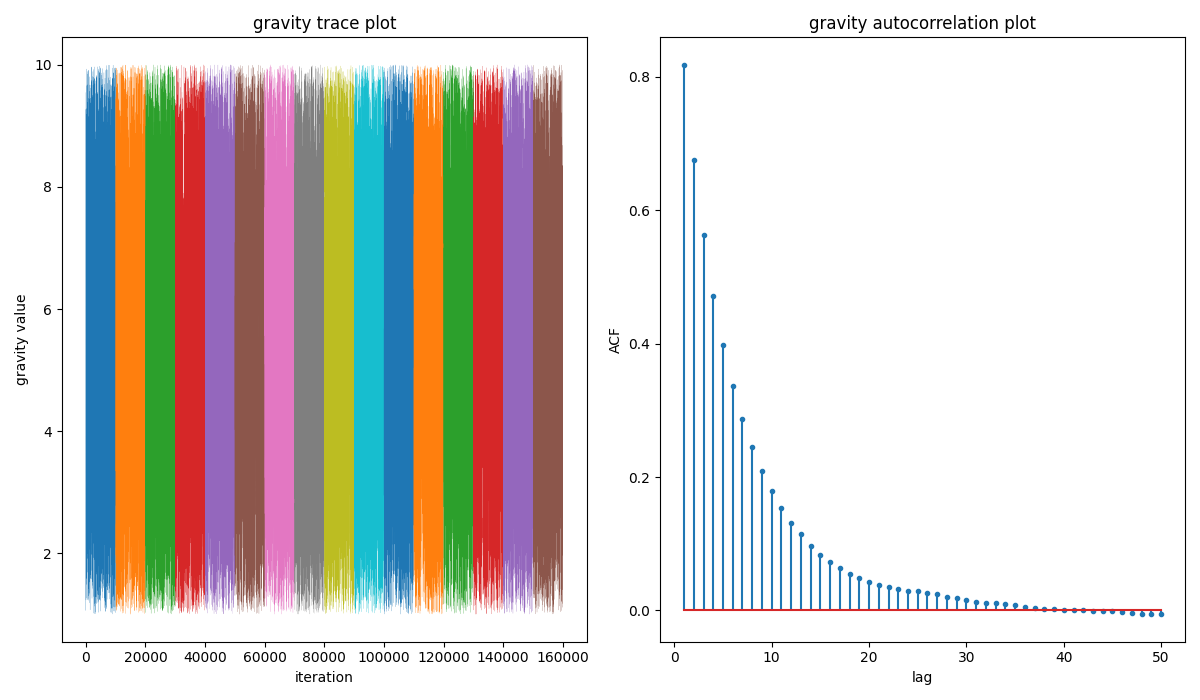

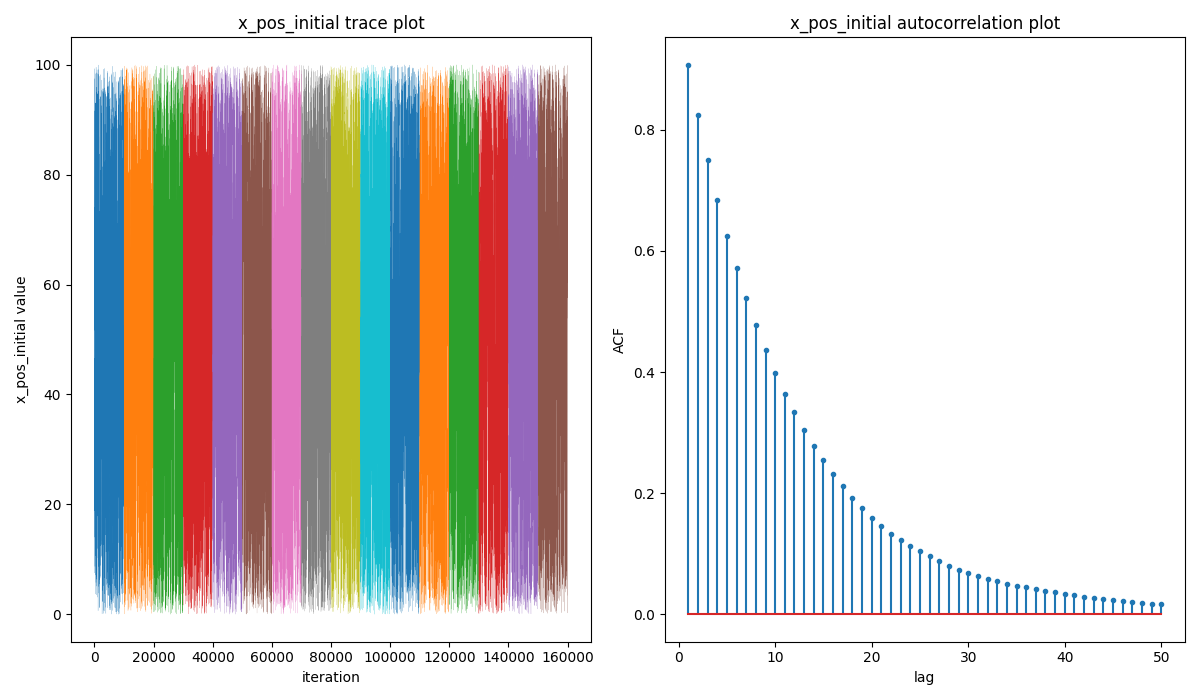

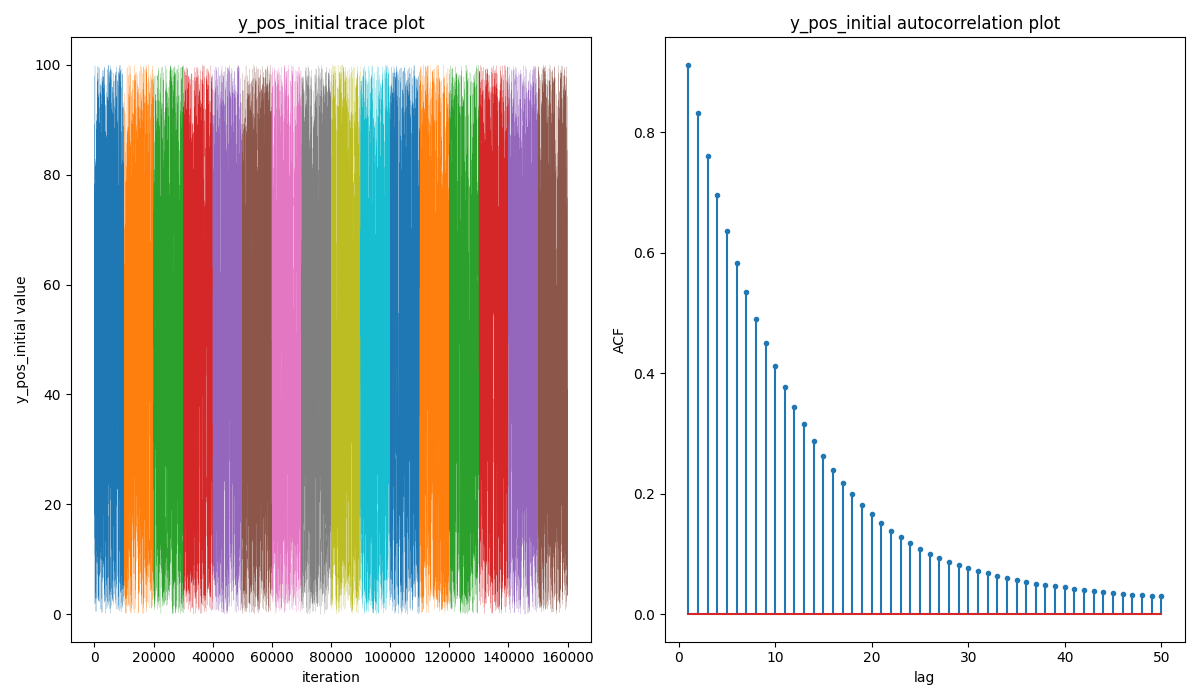

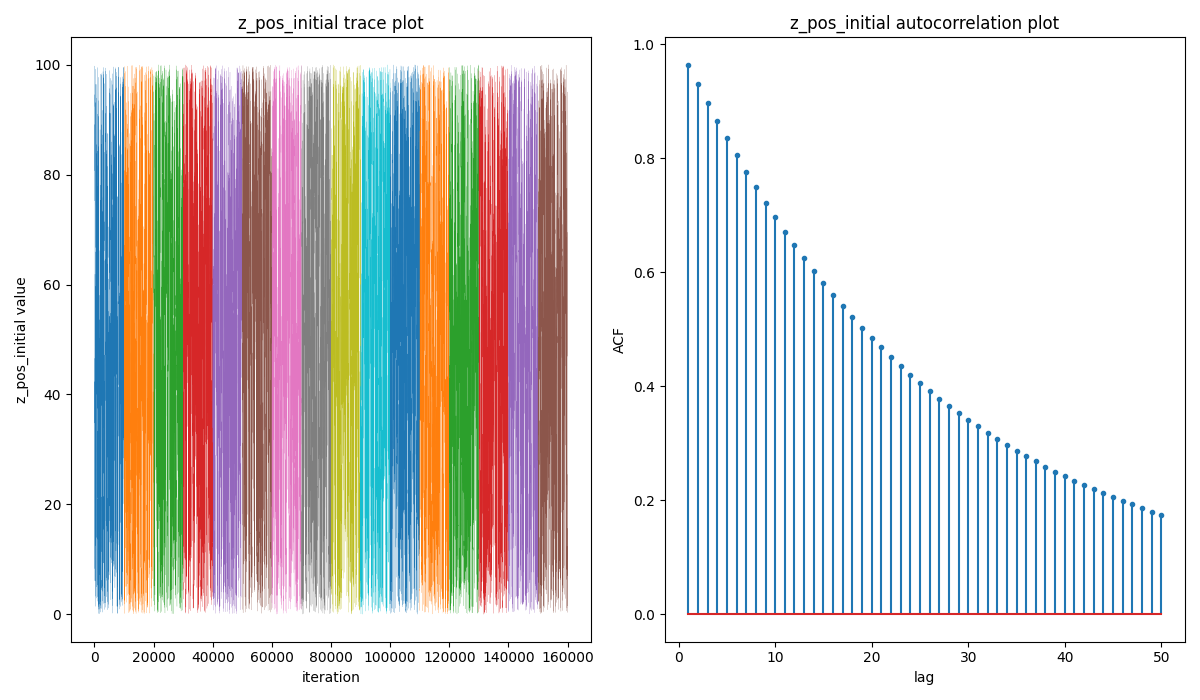

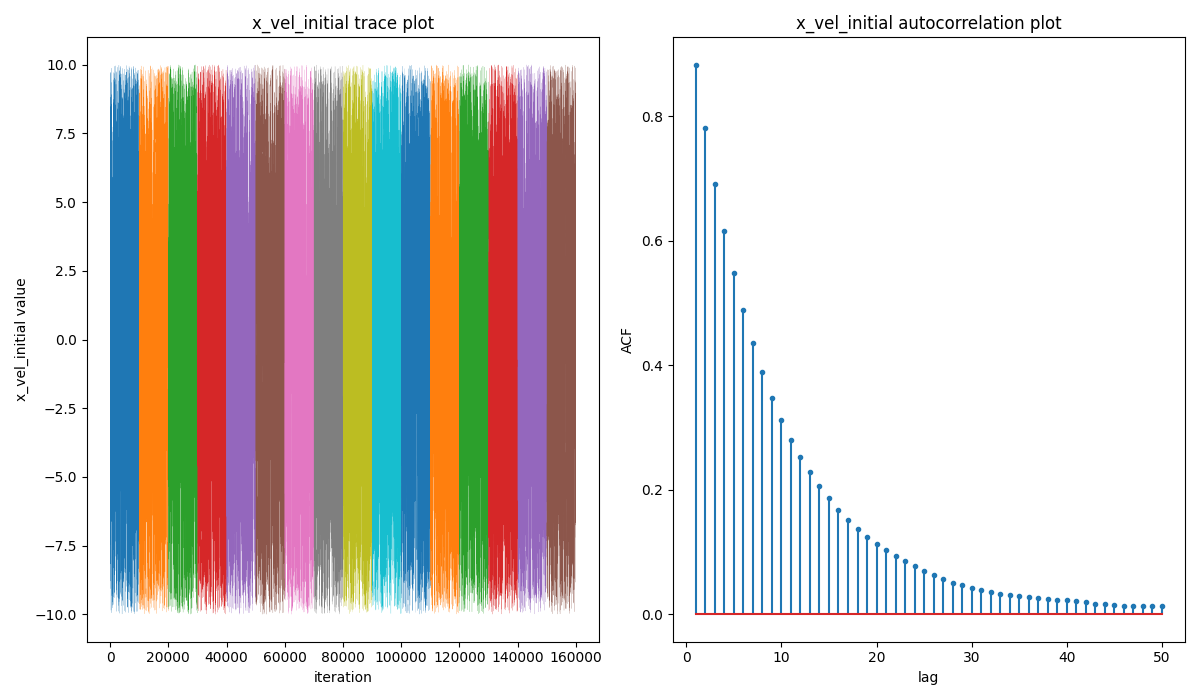

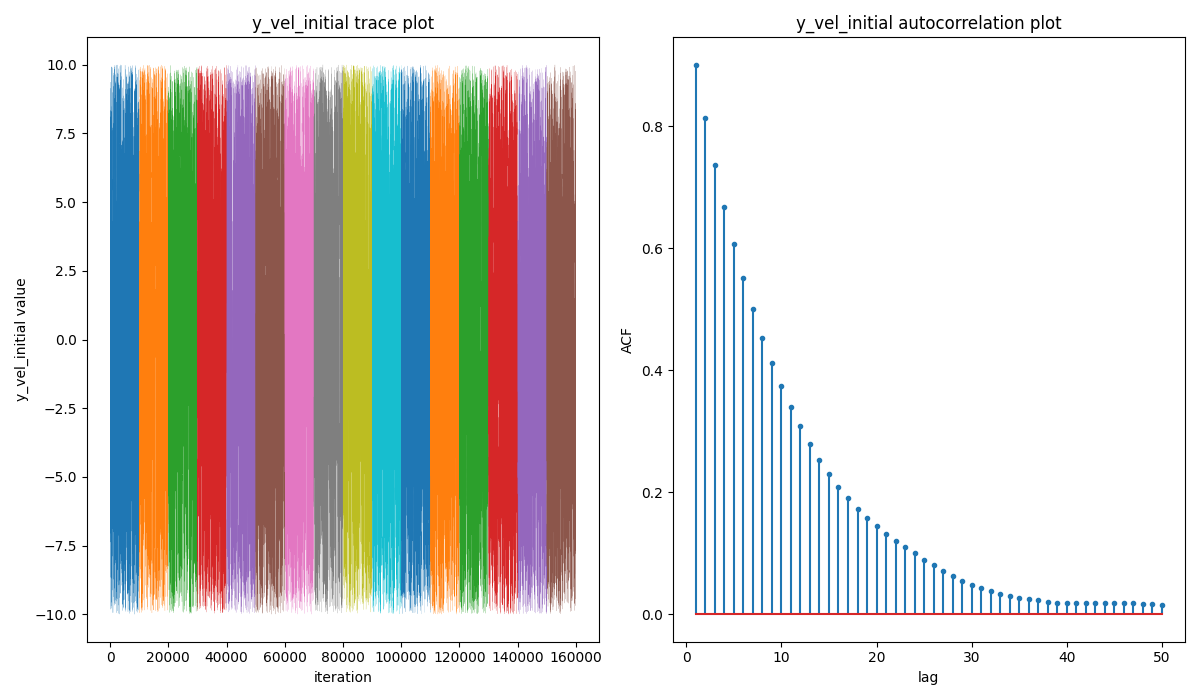

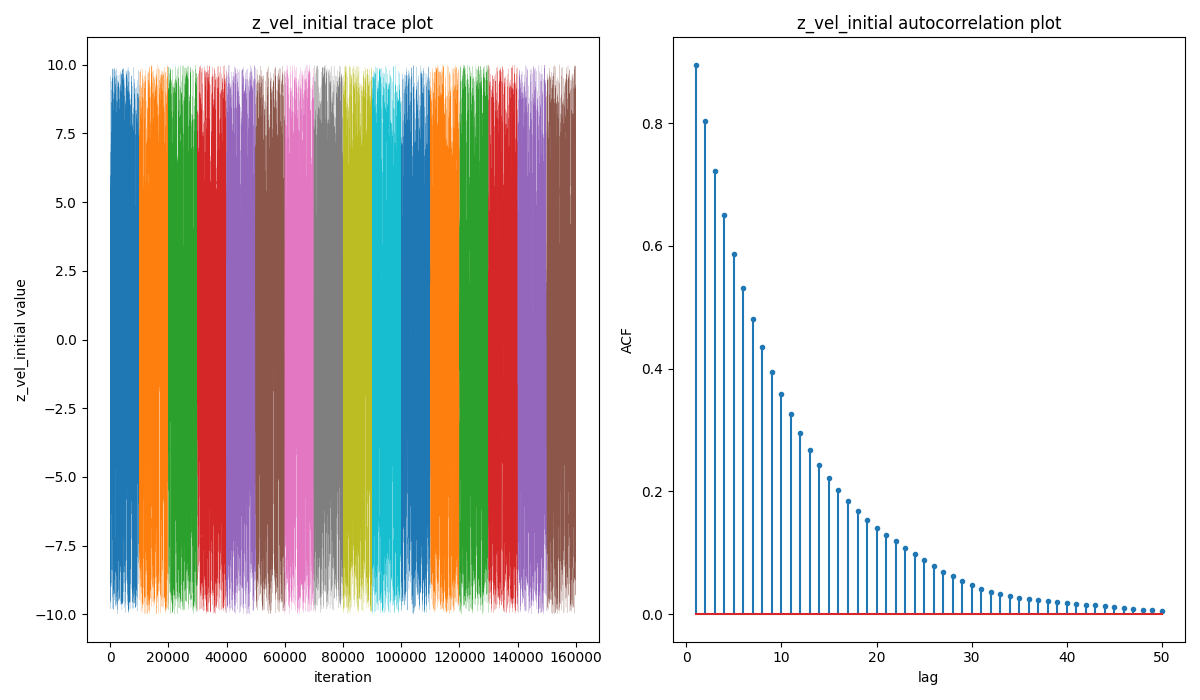

In [6]:

auto_trace(['gravity','x_pos_initial','y_pos_initial','z_pos_initial','x_vel_initial','y_vel_initial','z_vel_initial'])


### Before only the prior was considered, now the likelihood is calculated

In [7]:

vanilla_exp.run_chain(total=10000, burn=10000, every=30, n_chains=16, prior_only=False)
print(vanilla_exp.diagnostics_string())

post_chains = vanilla_exp.get_chains(flattened=True)
post_points = np.stack(post_chains.values()).T

Burning
Burning

BurningBurning
Burning
Burning
Burning
Burning
Burning
Burning
Burning
Burning
Burning
Burning
Burning
Burning
Sampling Start
Sampling Start
Sampling StartSampling Start

Sampling Start
Sampling Start
Sampling Start
Sampling Start
Sampling Start
Sampling Start
Sampling Start
Sampling Start
Sampling Start
Sampling Start
Sampling Start
Sampling Start
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 10%Sampling: 10%

Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 10%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 20%
Sampling: 30%
Sampling: 30%
Sampling: 30%
Sampling: 30%
Sampling: 30%
Sampling: 30%
Sampling: 30%
Sampling: 30%
Sampling: 30%
Sampling: 30%
Sampling: 30%
Sampling: 30%
Sampling: 30%
Sa

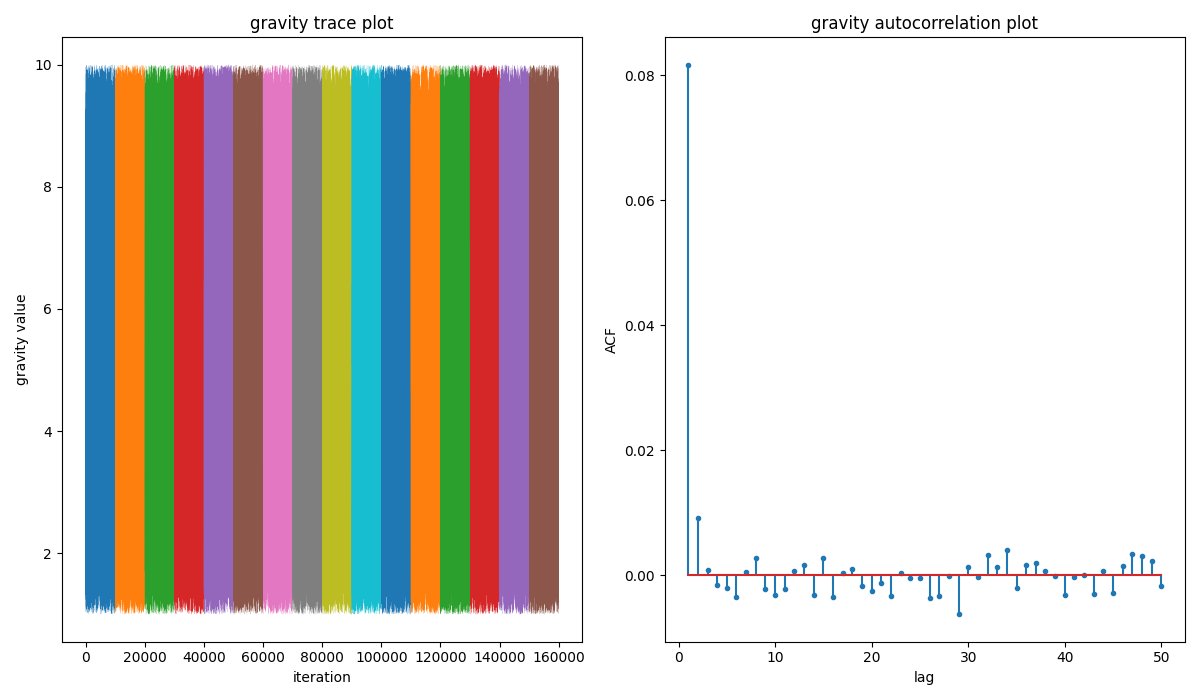

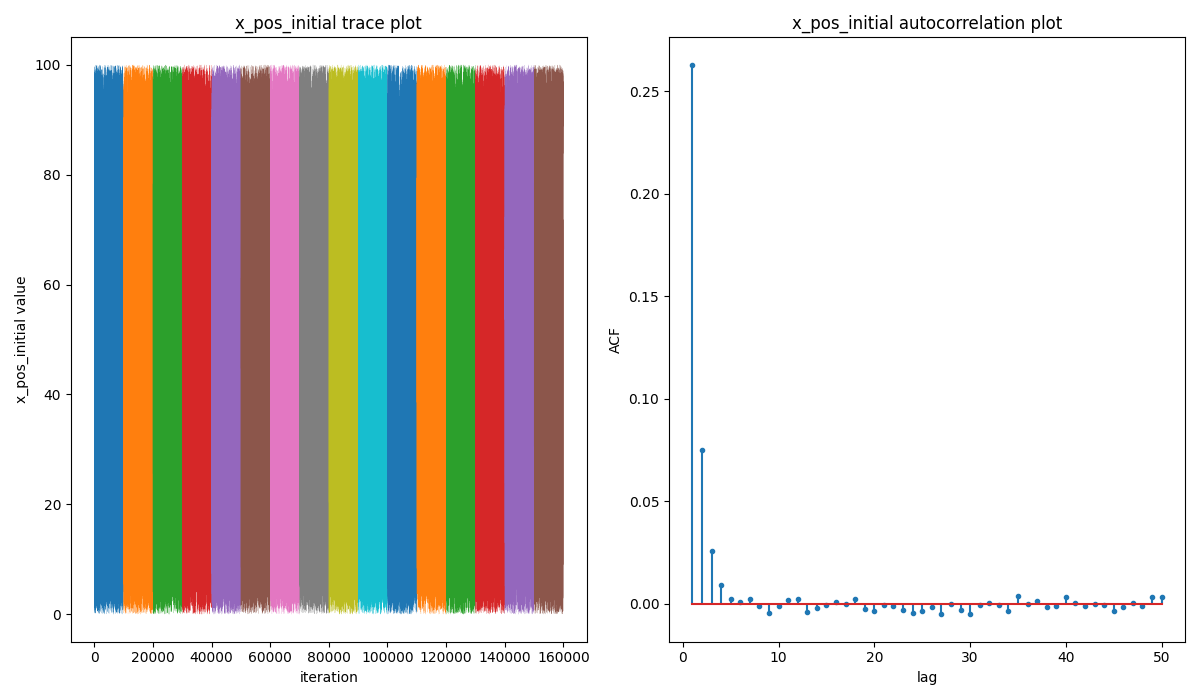

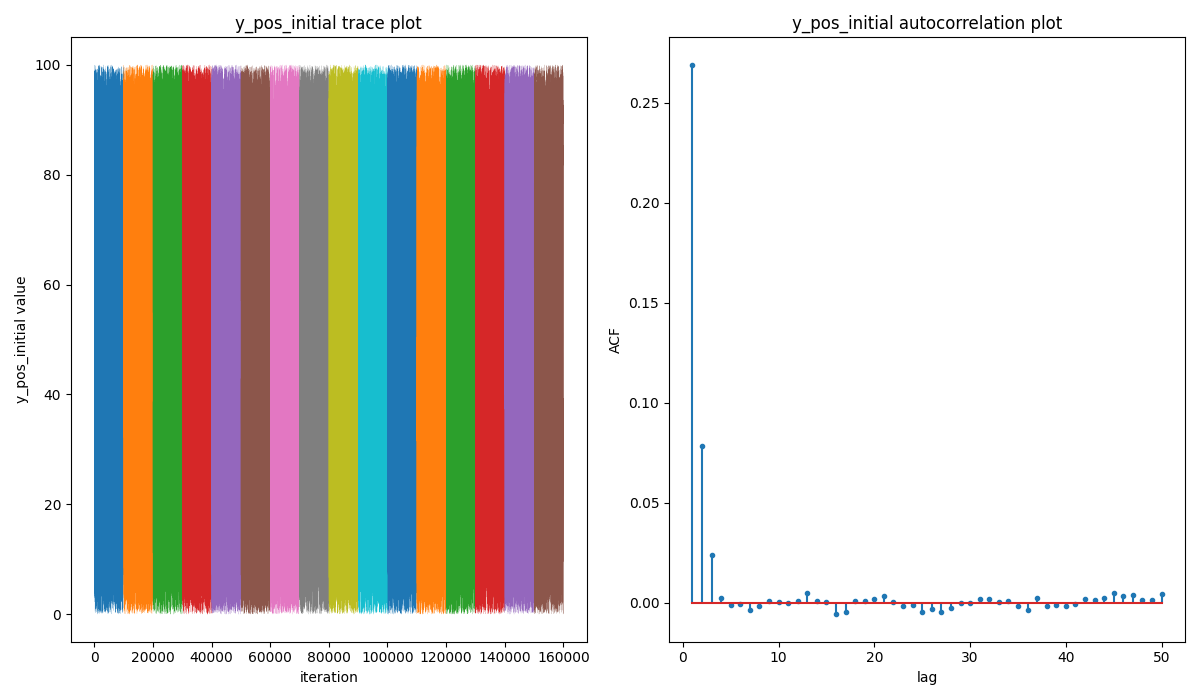

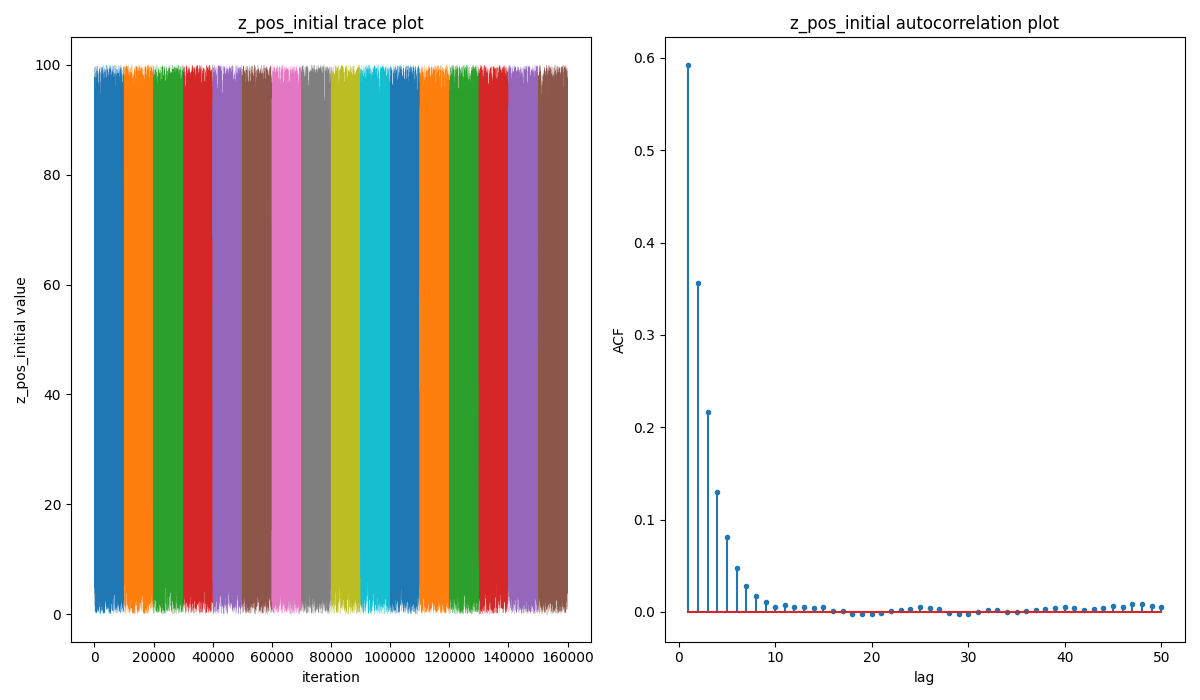

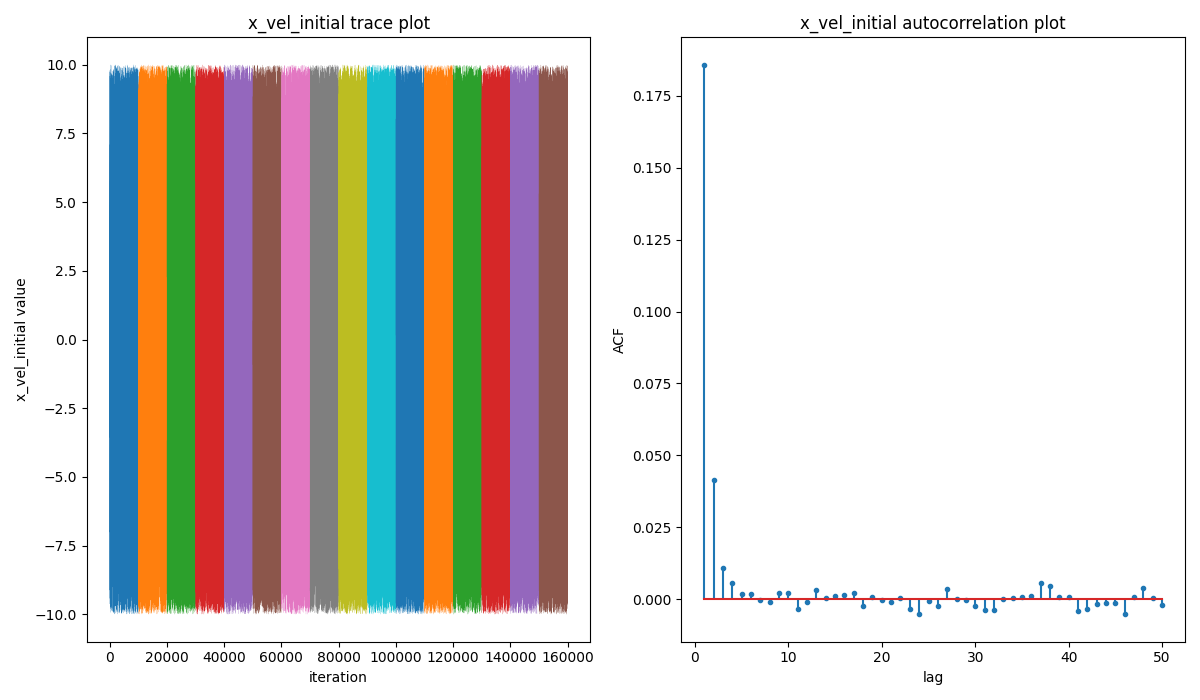

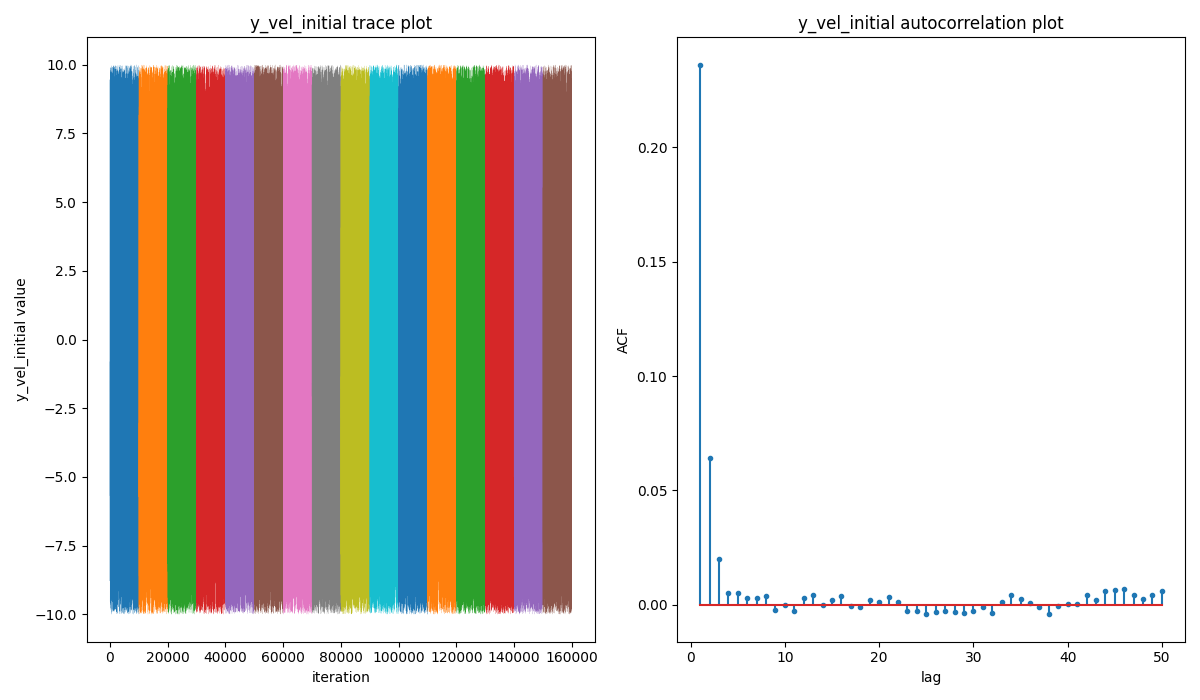

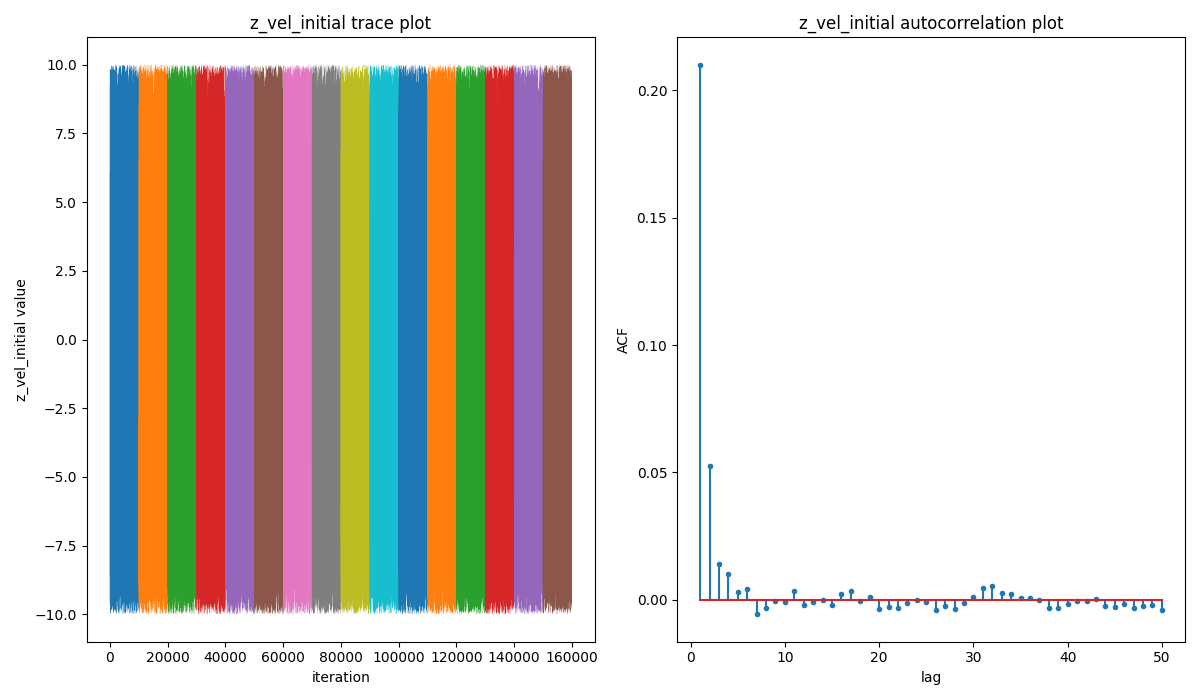

In [10]:
auto_trace(['gravity','x_pos_initial','y_pos_initial','z_pos_initial','x_vel_initial','y_vel_initial','z_vel_initial'])

### Likelihood Plots

/g/g20/eljurf1/weave_demos/ball_bounce/ball_bounce_demo_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


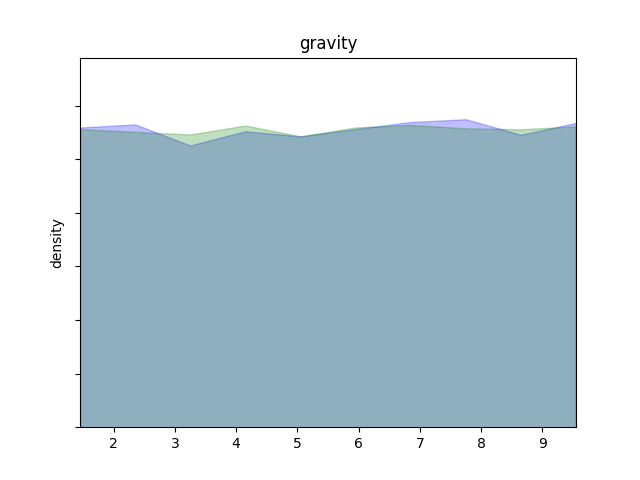

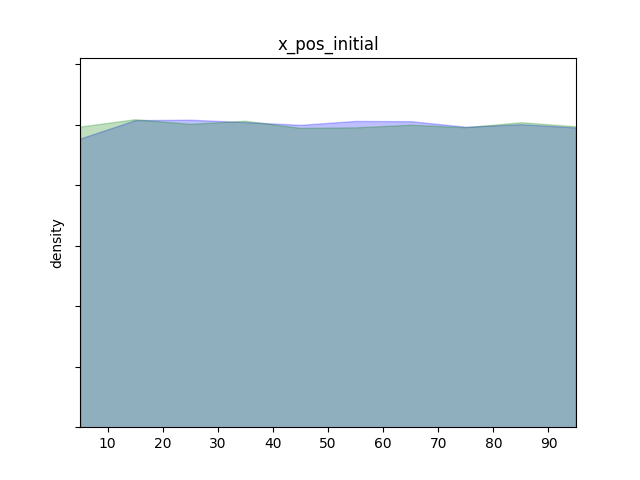

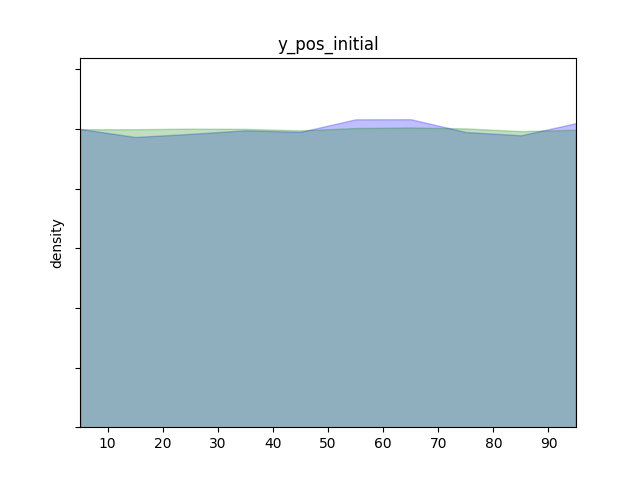

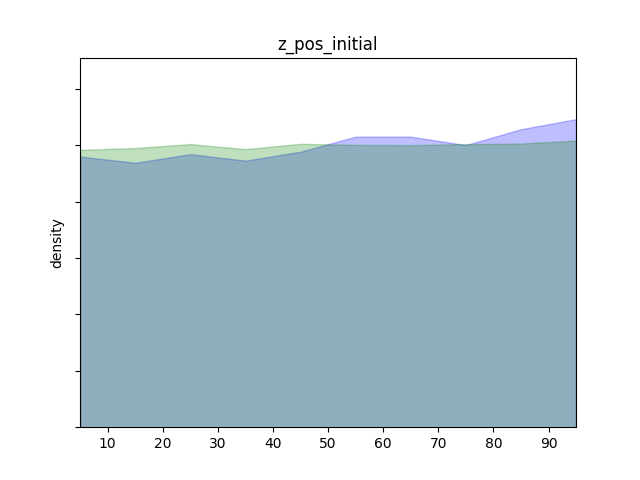

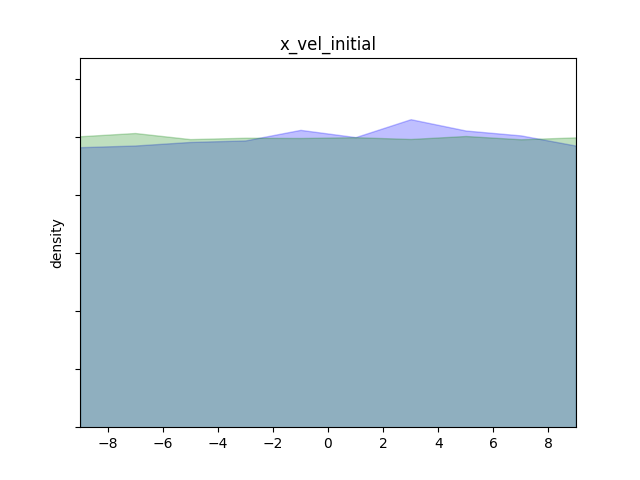

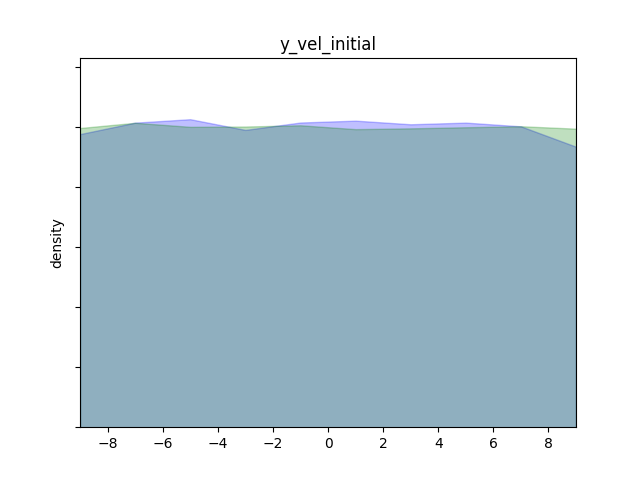

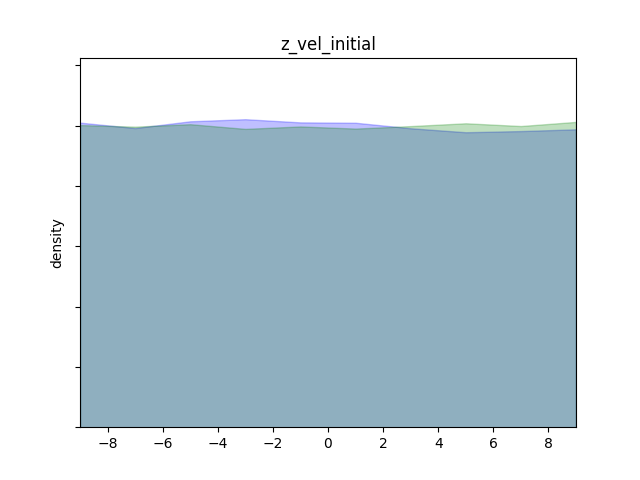

In [14]:
for key in post_chains.keys():
    fig, ax = plt.subplots(1, 1)
    ax.title.set_text(key)
    plots.likelihood_plot(ax, prior_chains[key], post_points=post_chains[key])


### Diagnostics

$\hat{R}$ is a diagnostic that determines convergence (whether or not the chain has fully explored the whole distribution.) This value depends on the variance within chains and between chains. If this is too high it means that the chain has not been run long enough to fully converge to the target distribution.

We need to adjust our `run_chain` parameters to allow for convergence. 

### Appendix

#### Metropolis algorithm 

Provides a mechanism to explore the entire configuration space by random walk. At each step, the algorithm performs a random modification to the current state to obtain a new state. The new state is either accepted or rejected with a probability computed based on energy change in the transition. The states generated by the algorithm form a Markov chain.

|Metropolis Algorithm|
|--------------------|
|1: Randomize an input $g$.|
|2: **repeat** |
|3: &nbsp; Generate $g^*$ by performing a random trial move from $g$.|
|4: &nbsp; Compute $Pr(g \rightarrow g^*)=$ min $\left\{1,\frac{Pr(g^*)}{Pr(g)}\right\}$|
|5: &nbsp; if _random_ $(0,1]<Pr(g \rightarrow g^*)$ then $g \rightarrow g^*$.|
|6: **until** equilibrium is attained.|


#### Gibbs sampler 
A special case of the Metropolis algorithm, which generates new states by using univariate conditional probabilities. Because direct sampling from the complex joint distribution of all random variables is difficult, Gibbs sampler instead simulate random variables one by one from the univariate conditional distribution. A univariate conditional distribution involves only one random variable conditioned on the rest variables having fixed values, which is usually in a simple mathematical form.

|Gibbs Sampling Algorithm|
|------------------------|
|1: Randomize an input $g$.|
|2: **repeat** |
|3: &nbsp; **for all** $i \in R$ **do**|
|4: &nbsp;&nbsp;&nbsp;&nbsp; Compute $Pr(g_i = q \| g^i)$ for all $q \in Q$.|
|5: &nbsp;&nbsp;&nbsp;&nbsp; Assign $g_i$ to the value $q$ with the probability $Pr(g_i = q \| g^i)$.|
|6: &nbsp; **end for** |
|7: **until** equilibrium is attained.|